In [2]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seawater as sw

# Simple Example

### Artificial density field (Cyclone)

In [391]:
dz=200
dx=150

In [392]:
# z0=-np.linspace(0,200,dz) #upward positive, surface=0
z0=np.linspace(0,200,dz)[::-1] #upward positive, bottom=0

x=np.linspace(-120,120,dx)

z_matrix=np.tile(z0,(x.shape[0],1)).T
x_matrix=np.tile(x,(z0.shape[0],1))

t_out=np.linspace(20,26,z0.shape[0])[::-1]
t_in=np.linspace(23.5,26.1,z0.shape[0])[::-1]

# t_out=np.linspace(22,23.8,z0.shape[0])[::-1]
# t_in=np.linspace(23.5,23.8,z0.shape[0])[::-1]



r0=120

T_out=np.tile(t_out,(x.shape[0],1))
T_in=np.tile(t_in,(x.shape[0],1))

T=(T_out + (T_in-T_out)*np.exp(-((x_matrix.T/r0)**2))).T
rho_est=sw.dens0(s=36,t=T)
g=9.8

In [393]:
rho=xr.DataArray(data=rho_est,
                 coords={'distance':(('x','z'),x_matrix),'depth':(('x','z'),z_matrix)},
                 dims=['x','z'])

rho_levels=np.linspace(rho.min(),rho.max(),15)

Drho_z=np.abs(np.gradient(np.nanmean(rho,axis=1))/np.diff(z0)[0]).max()
Drho_x=np.abs(np.gradient(np.nanmean(rho,axis=0))/np.diff(x)[0]).max()

In [394]:
#plot specs

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

xdec=(x.max()*2)/5

# Density Field

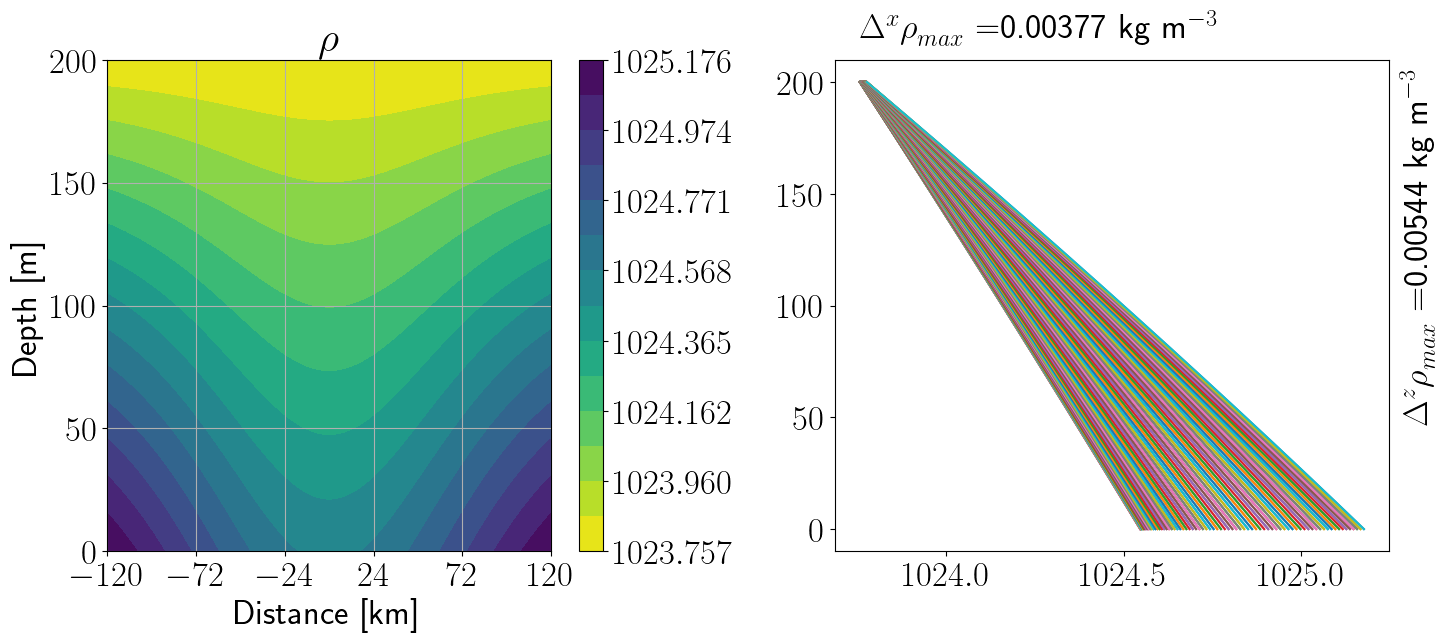

In [395]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.contourf(x,z0,rho,levels=rho_levels,cmap='viridis_r')
plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$\rho$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,2,2)
plt.plot(rho,z0)

plt.text(rho.max()+0.1,z0.max()/4,r'${\Delta^z\rho}_{max}$ ='+'{:.5f}'.format(Drho_z) + r' kg m$^{-3}$',rotation=90)
plt.text(rho.min(),z0.max()+20,r'${\Delta^x\rho}_{max}$ ='+'{:.5f}'.format(Drho_x) + r' kg m$^{-3}$')


plt.tight_layout()

### Sorting density

In [401]:
# "xarray method (not working)"
# rho_stacked=rho.stack(z_star=("x","z"))
# rho_sorted=rho_stacked.copy().sortby(rho_stacked.copy())
# rho_star=rho_sorted.unstack('z_star')

"numpy method (working but janky)"
rho_stacked=np.ravel(rho)
index_sorted=np.argsort(rho_stacked)

# rho_sorted=np.sort(rho_stacked)
# rho_star=rho_sorted.reshape(rho.shape)
rho_m=np.tile(np.nanmean(rho,axis=1),(x.shape[0],1)).T
rho_star=rho.copy(data=rho_stacked[index_sorted].reshape(rho.shape))
rho_star_m=rho.copy(data=np.tile(np.nanmean(rho_star,axis=1),(x.shape[0],1)).T)




In [408]:
# 'ZSTAR. old method: assuming that rho* is approx mean(rho*)'

# z_stacked=np.ravel(z_matrix)
# z_star=rho.copy(data=z_stacked[index_sorted].reshape(rho.shape))

In [407]:
%%time
'ZSTAR. new method: assuming that rho* is approx mean(rho*)'
z_star=z_matrix.copy()*np.nan

for xx in range(x.shape[0]):
    for zi in range(z0.shape[0]):
        z_star[zi,xx]=z0[np.argmin(np.abs(rho[zi,xx]-rho_star[:,xx]).data)]

CPU times: user 14.5 s, sys: 58.9 ms, total: 14.6 s
Wall time: 14.6 s


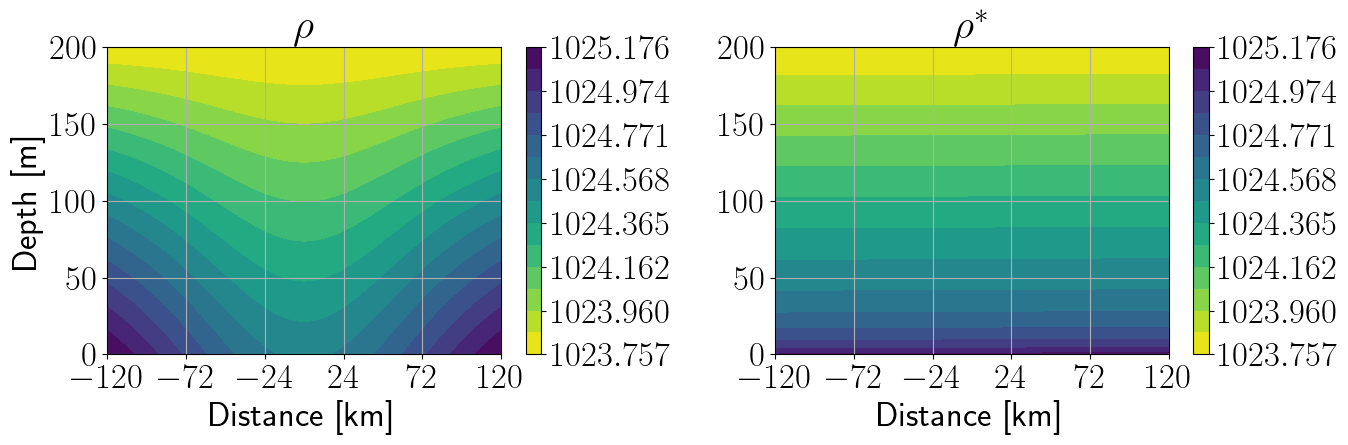

In [409]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.contourf(x,z0,rho,levels=rho_levels,cmap='viridis_r')
plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$\rho$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,3,2)
# rho_star.plot(x='distance',y='depth',cmap='viridis_r')
# plt.pcolormesh(rho['distance'],z0,rho_star,cmap='viridis_r')
plt.contourf(x,z0,rho_star,levels=rho_levels,cmap='viridis_r')

plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('')
plt.title(r'$\rho^*$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()



plt.tight_layout()

 $\rho(z*)$ is (approximately) only a function of z

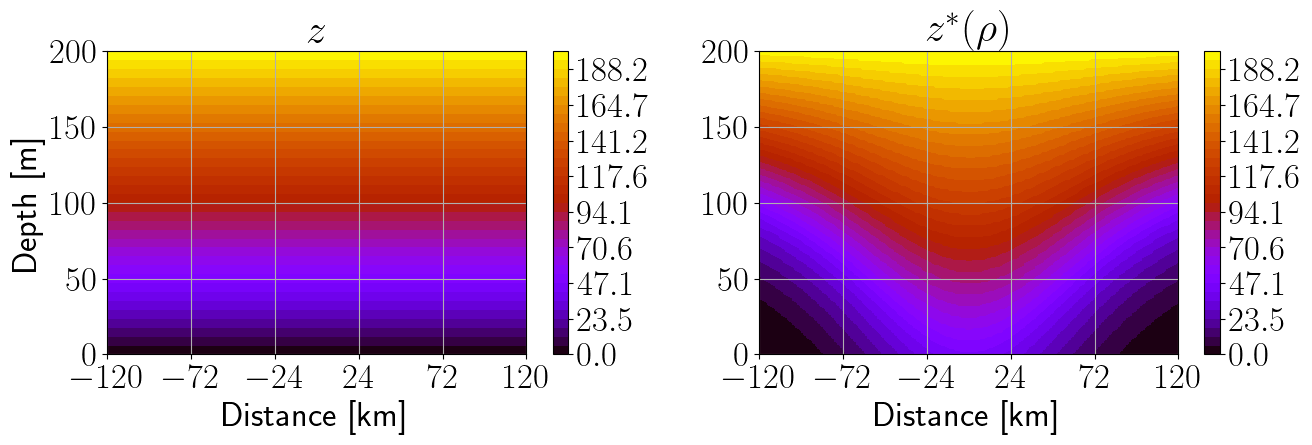

In [410]:
z_levels=np.linspace(z0.min(),z0.max(),35)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,z_matrix,levels=z_levels,cmap='gnuplot')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$z$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,3,2)
# rho_star.plot(x='distance',y='depth',cmap='viridis_r')
# plt.pcolormesh(x,z0,z_star,cmap='jet_r')
plt.contourf(x,z0,z_star,levels=z_levels,cmap='gnuplot')

plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('')
plt.title(r'$z^*(\rho)$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()


plt.tight_layout()

In [411]:
if ((np.diff(z0).mean()<0)& (z0[0]==0)):
    PE=-g*rho*z_matrix #upward positive, surface=0
    BPE=-g*rho*(z_star)
    APE=-g*rho*(z_matrix-z_star)
else:
    PE=g*rho*z_matrix #upward positive, surface=0
    BPE=g*rho*(z_star)
    APE=g*rho*(z_matrix-z_star)


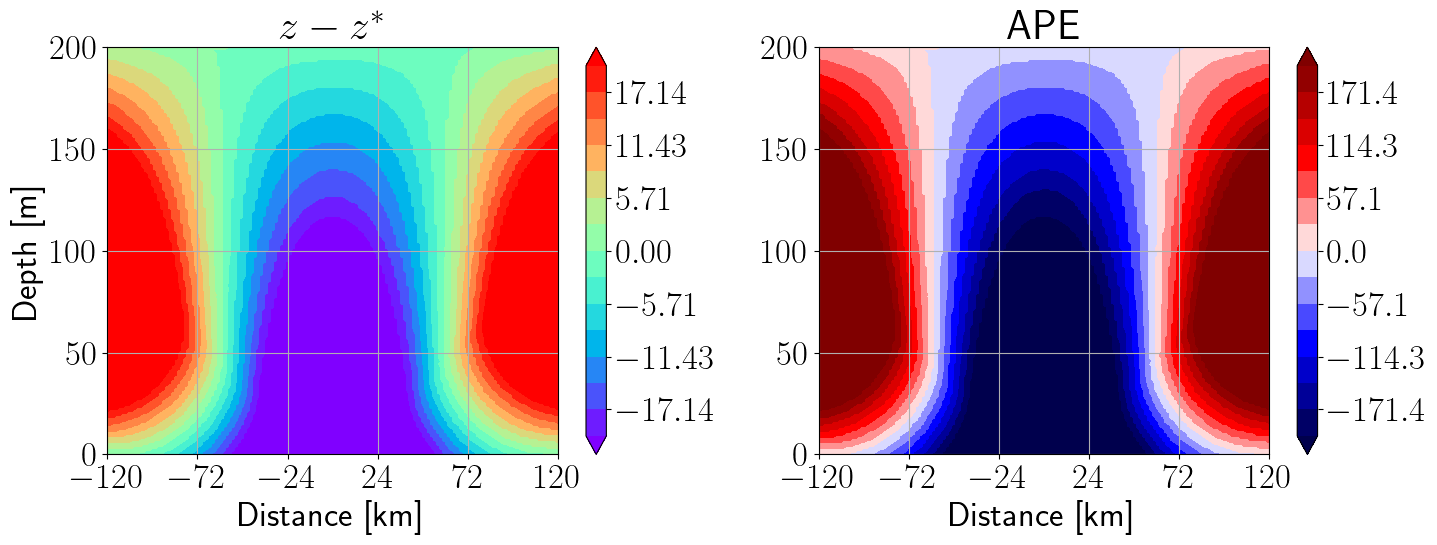

In [412]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,z_matrix-z_star,levels=np.linspace(-20,20,15),extend='both',cmap='rainbow')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$z-z^*$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.subplot(1,2,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,APE/1e3,extend='both',levels=np.linspace(-200,200,15),cmap='seismic')
plt.colorbar()

plt.xlabel('Distance [km]')
# plt.ylabel('Depth [m]')
plt.title(r'APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()

plt.tight_layout()

/tmp/ipykernel_1559594/1222786036.py:6: UserWarning: The following kwargs were not used by contour: 'level'
  c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')
/tmp/ipykernel_1559594/1222786036.py:19: UserWarning: The following kwargs were not used by contour: 'level'
  c2=plt.contourf(x,z0,BPE/scale,level=np.linspace(BPE.min()/scale,BPE.max()/scale,35),cmap='GnBu')


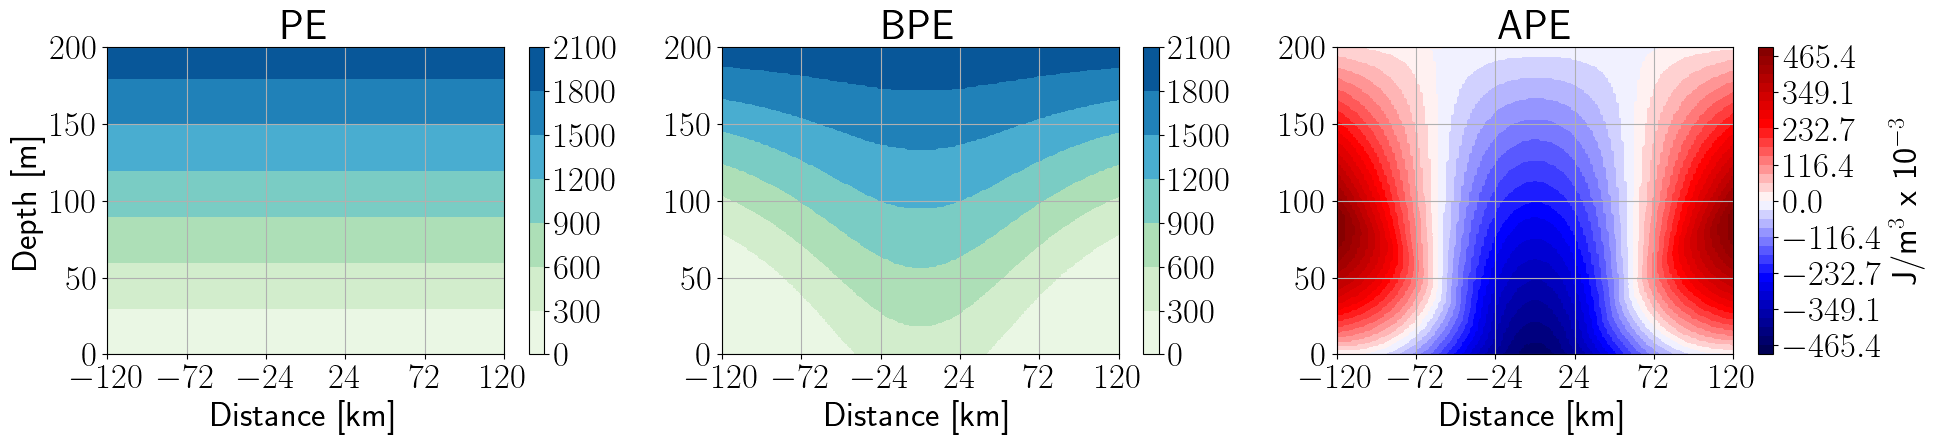

In [414]:
scale=1e3
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'PE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.colorbar()
plt.grid()


plt.subplot(1,3,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c2=plt.contourf(x,z0,BPE/scale,level=np.linspace(BPE.min()/scale,BPE.max()/scale,35),cmap='GnBu')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.title(r'BPE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.subplot(1,3,3)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c3=plt.contourf(x,z0,APE/scale,levels=np.linspace(-np.abs(APE).max()/scale,np.abs(APE).max()/scale,35),cmap='seismic')
plt.colorbar(c3,label=r'J/m$^3$ x 10$^{-3}$')

plt.xlabel('Distance [km]')
plt.title(r'APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.tight_layout()

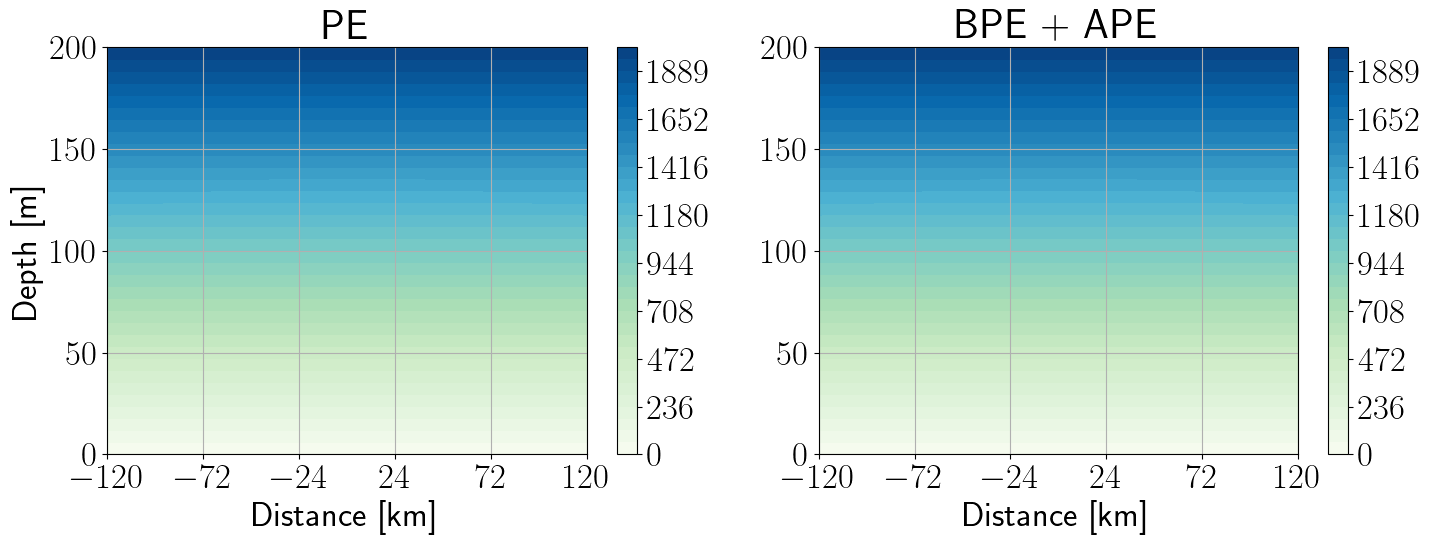

In [415]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c1=plt.contourf(x,z0,PE/scale,levels=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'PE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.colorbar()
plt.grid()


plt.subplot(1,2,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c2=plt.contourf(x,z0,(BPE+APE)/scale,levels=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.title(r'BPE + APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()

plt.tight_layout()